In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('movies.csv')
df = pd.merge(df, pd.read_csv('dataBase/title.basics2.tsv', sep='\t'), left_on='MovieID', right_on='tconst')

In [4]:
df.drop(['originalTitle_x', 'runtimeMinutes_x', 'runtimeMinutes_y', 'avgRating', 'numVotes','image', 'tconst', 'primaryTitle_y', 'originalTitle_y', 'startYear'], axis=1, inplace=True)

In [5]:
df.genres = df.genres.str.split(',')

In [6]:
print(df.head())

     MovieID      primaryTitle_x  Year  \
0  tt0016029  The Little Colonel  1935   
1  tt0017961           Happiness  1935   
2  tt0020163    People on Sunday  1930   
3  tt0020298         Queen Kelly  1932   
4  tt0020620     Abraham Lincoln  1930   

                                                plot  \
0  After Southern belle Elizabeth Lloyd runs off ...   
1  A hapless loser (with the surname of Loser) un...   
2  A semi-documentary experimental 1930 German si...   
3  A prince betrothed to a mad queen falls in lov...   
4  A biopic dramatizing Abraham Lincoln's life th...   

                      genres  
0  [Comedy, Family, Musical]  
1            [Comedy, Drama]  
2   [Comedy, Drama, Romance]  
3                    [Drama]  
4    [Biography, Drama, War]  


In [7]:
unique_genres = set(genre for sublist in df['genres'] for genre in sublist)
for genre in unique_genres:
    df[genre] = 0
    
for i, row in df.iterrows():
    for genre in row['genres']:
        df.at[i, genre] = 1

In [8]:
df.drop(['genres'], axis=1, inplace=True)

In [9]:
df_pca = df.drop(['MovieID', 'primaryTitle_x', 'plot'], axis=1)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
    
scaler = StandardScaler()
df_pca = scaler.fit_transform(df_pca)
pca = PCA(n_components=15)
df_pca = pca.fit_transform(df_pca)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))



[0.0763974  0.07198368 0.06429292 0.05890648 0.05115239 0.04830665
 0.04443214 0.04151615 0.04089349 0.04054835 0.04012105 0.03930765
 0.03888294 0.03813626 0.0369543 ]
0.7318318409096346


In [11]:
# DBSCAN clustering using p. components
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
    
db = DBSCAN(eps=0.3, min_samples=10).fit(df_pca)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 286
Estimated number of noise points: 3334


[236 234 150 ... 119 100  27]


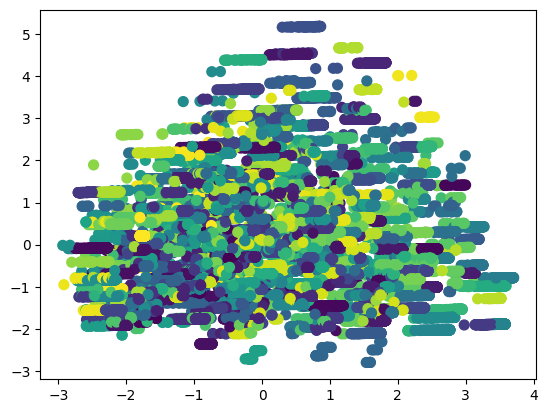

In [12]:
# KMeans clustering using p. components
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=286, random_state=0).fit(df_pca)
print(kmeans.labels_)

import matplotlib.pyplot as plt
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, s=50, cmap='viridis')


In [13]:
# Testing result of clustering
df['cluster'] = kmeans.labels_
print(df[df['cluster'] == 0])


         MovieID                primaryTitle_x  Year  \
390    tt0026752          Mutiny on the Bounty  1935   
747    tt0032281                 Brigham Young  1940   
970    tt0034734                      Spitfire  1942   
1142   tt0036582  The Adventures of Mark Twain  1944   
1252   tt0037576                  Captain Kidd  1945   
...          ...                           ...   ...   
39166  tt6805354      Gabriel and the Mountain  2017   
39480  tt7084386                  Blue Miracle  2021   
39804  tt7388562       Paul, Apostle of Christ  2018   
40947  tt8526164                Exterior/Night  2018   
41297  tt8983230                    Broad Peak  2022   

                                                    plot  Film-Noir  News  \
390    Fletcher Christian successfully leads a revolt...          0     0   
747    Based on the story of the famous Mormon leader...          0     0   
970    This 1942 fictionalized biopic chronicles the ...          0     0   
1142   A dramatised

In [14]:
df['title'] = df['primaryTitle_x'] + ' (' + df['Year'].astype(str) + ')'

In [15]:
# df_cluster = df[['MovieID', 'title', 'cluster']].copy()
df_all = pd.read_csv('movies.csv')
df_all['title'] = df_all['primaryTitle'] + ' (' + df_all['Year'].astype(str) + ')'
df_all['cluster'] = df.cluster
df_all.to_csv('movies_clustered.csv', index=False)

In [26]:
df1 = pd.read_csv('movies_clustered.csv')
def recommendations_cluster_sorted(title):
    target_cluster = df1[df1['title'] == title].cluster
    movies_in_cluster = df1[df1['cluster'] == target_cluster.values[0]].title.tolist()
    # sort by numVotes * avgRating
    rec = []
    for movie in movies_in_cluster:
        rec.append((movie, df1[df1['title'] == movie].numVotes.values[0] * df1[df1['title'] == movie].avgRating.values[0]))
    rec = sorted(rec, key=lambda x: x[1], reverse=True)
    # Top 10:
    rec = [x[0] for x in rec[:10]]
    return rec

cluster_rec = recommendations_cluster_sorted('Harry Potter and the Sorcerer\'s Stone (2001)')
print(cluster_rec)

['Harry Potter and the Deathly Hallows: Part 2 (2011)', "Harry Potter and the Sorcerer's Stone (2001)", 'Harry Potter and the Prisoner of Azkaban (2004)', 'Harry Potter and the Goblet of Fire (2005)', 'Harry Potter and the Chamber of Secrets (2002)', 'Harry Potter and the Deathly Hallows: Part 1 (2010)', 'Fantastic Beasts and Where to Find Them (2016)', 'The Wizard of Oz (1939)', 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe (2005)', 'Alice in Wonderland (2010)']


In [17]:
df['plot'] = df['plot'].fillna('')

In [19]:
import nltk
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet') 
  
  
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
  
from nltk.corpus import stopwords 
nltk.download('stopwords') 
stop_words = set(stopwords.words('english')) 
  
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'} 

def preprocess_sentences(text): 
  text = text.lower() 
  temp_sent =[] 
  words = nltk.word_tokenize(text) 
  tags = nltk.pos_tag(words) 
  for i, word in enumerate(words): 
      if tags[i][1] in VERB_CODES:  
          lemmatized = lemmatizer.lemmatize(word, 'v') 
      else: 
          lemmatized = lemmatizer.lemmatize(word) 
      if lemmatized not in stop_words and lemmatized.isalpha(): 
          temp_sent.append(lemmatized) 
          
  finalsent = ' '.join(temp_sent) 
  finalsent = finalsent.replace("n't", " not") 
  finalsent = finalsent.replace("'m", " am") 
  finalsent = finalsent.replace("'s", " is") 
  finalsent = finalsent.replace("'re", " are") 
  finalsent = finalsent.replace("'ll", " will") 
  finalsent = finalsent.replace("'ve", " have") 
  finalsent = finalsent.replace("'d", " would") 
  return finalsent 
  
df["plot_processed"]= df["plot"].apply(preprocess_sentences) 
df.head() 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/baiyizhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/baiyizhang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/baiyizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/baiyizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,MovieID,primaryTitle_x,Year,plot,Film-Noir,News,Animation,Crime,Sport,Sci-Fi,...,Musical,Adventure,Adult,Western,Music,Drama,Family,cluster,title,plot_processed
0,tt0016029,The Little Colonel,1935,After Southern belle Elizabeth Lloyd runs off ...,0,0,0,0,0,0,...,1,0,0,0,0,0,1,236,The Little Colonel (1935),southern belle elizabeth lloyd run marry yanke...
1,tt0017961,Happiness,1935,A hapless loser (with the surname of Loser) un...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,234,Happiness (1935),hapless loser surname loser undergo misadventu...
2,tt0020163,People on Sunday,1930,A semi-documentary experimental 1930 German si...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,150,People on Sunday (1930),experimental german silent film create amateur...
3,tt0020298,Queen Kelly,1932,A prince betrothed to a mad queen falls in lov...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,38,Queen Kelly (1932),prince betroth mad queen fall love orphan girl...
4,tt0020620,Abraham Lincoln,1930,A biopic dramatizing Abraham Lincoln's life th...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,52,Abraham Lincoln (1930),biopic dramatize abraham lincoln life series v...


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer 
  
# Vectorizing pre-processed movie plots using TF-IDF 
tfidfvec = TfidfVectorizer() 
tfidf_movieid = tfidfvec.fit_transform((df["plot_processed"])) 
  
# Finding cosine similarity between vectors 
from sklearn.metrics.pairwise import cosine_similarity 
cos_sim = cosine_similarity(tfidf_movieid, tfidf_movieid) 

In [21]:
# Storing indices of the data 
# indices = pd.Series(df.index) 
indices = pd.Series(df.index, index = df['title']).drop_duplicates()
def recommendations(title, cosine_sim = cos_sim): 
    recommended_movies = [] 
    index = indices[title]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False) 
    top_10_movies = list(similarity_scores.iloc[1:11].index) 
    for i in top_10_movies: 
        recommended_movies.append(list(df['title'])[i]) 
    return recommended_movies 

In [23]:
cos_rec = recommendations('Harry Potter and the Sorcerer\'s Stone (2001)')
print(cos_rec)

['Harry Potter and the Chamber of Secrets (2002)', 'With a Friend Like Harry... (2000)', 'Harry Potter and the Order of the Phoenix (2007)', 'The Third Man (1949)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Dumb and Dumber To (2014)', 'Harry Potter and the Goblet of Fire (2005)', 'MI-5 (2015)', "Let's Get Harry (1986)", 'The Eighth Day (1996)']
